In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Model
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from keras.models import Sequential 
from keras.layers import Activation, Dense 
from keras.optimizers import RMSprop

# Plots
import plotly.express as px

# Preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

## Notes

1. Determine if a given location will have drought
2. Because train, test, and validation.csv contain too large records for the project, only use train.csv(19300680 records) and sample the subset of the data for both training and testing.
3. The problem is class imbalance where nan values (no drought) are the majority. For this issue, we undersample portion of no drought data to match the number of each other class (0 to 4 level of drought)
4. Columns with SQ1 ~ SQ7 contain integer values which indicate the levels of each feature. no need to standardize them

In [2]:
soil = pd.read_csv('data/soil.csv')
train = pd.read_csv('data/train.csv')

soil.shape, train.shape

((3109, 32), (19300680, 21))

Notice that fips is similar to ZIP code. One idea is to use fips instead of lat and lon when merging (or combining two dataframes)

In [3]:
soil.head(3)

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1


In [4]:
soil.columns

Index(['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3',
       'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE',
       'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND',
       'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND',
       'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7'],
      dtype='object')

In [5]:
train.head(3)

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN


**score** is the target variable

nan in score means no drought.

It ranges from 0 to 4 where 4 is the exceptional drought.

In [6]:
d_none = train[train['score'].isna()]
d0 = train[train['score']<1]
d1 = train[(train['score']>=1) & (train['score']<2)]
d2 = train[(train['score']>=2) & (train['score']<3)]
d3 = train[(train['score']>=3) & (train['score']<4)]
d4 = train[train['score']>=4]

In [7]:
d_none.shape[0], d0.shape[0], d1.shape[0], d2.shape[0], d3.shape[0], d4.shape[0]

(16543884, 1794623, 424353, 265995, 169049, 102776)

#### Notes

1. To make predictions simpler, instead of using floating points for targets, convert them into integers 0 to 4
2. nan values cannot be used for target variable. Assign the value of 9 for nan(no drought)

There are 6 different targets. Choose k values to sample from each data

In [9]:
k = 20000
random_state = 123

d_none = d_none.sample(k, random_state=random_state)
d0 = d0.sample(k, random_state=random_state)
d1 = d1.sample(k, random_state=random_state)
d2 = d2.sample(k, random_state=random_state)
d3 = d3.sample(k, random_state=random_state)
d4 = d4.sample(k, random_state=random_state)

d_none.shape[0], d0.shape[0], d1.shape[0], d2.shape[0], d3.shape[0], d4.shape[0]

(20000, 20000, 20000, 20000, 20000, 20000)

In [72]:
# Append all sets into one dataframe
df = pd.DataFrame()

for i, d in enumerate([d0, d1, d2, d3, d4, d_none]):
    
    if i == 5:
        d['score'] = 9
    else:
        d['score'] = i
    df = df.append(d, ignore_index=True)

In [73]:
df = df.merge(soil, on='fips', how='left')
df = df.drop(columns='date')

In [74]:
df.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,...,1.200000e+05,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.00000,120000.000000,120000.000000
mean,30236.781267,2.332326,95.781094,7.662575,13.808635,6.542439,6.587756,20.123376,8.103614,12.019791,...,2.545418e+01,4.301618,29.755794,1.785783,1.506092,1.275383,1.315058,1.13470,1.116558,1.281525
std,15443.630473,5.719392,6.194043,4.591977,11.121486,10.165509,10.099440,11.815867,10.677808,4.121191,...,3.028179e+01,11.493815,31.841450,1.149133,0.950835,0.939914,0.951772,0.84647,0.832934,0.961939
min,1001.000000,0.000000,67.120000,0.200000,-29.070000,-32.370000,-30.280000,-23.780000,-37.230000,0.370000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,17197.000000,0.000000,94.130000,3.710000,5.420000,-1.510000,-1.460000,11.630000,-0.090000,9.080000,...,7.450581e-09,0.047387,1.386391,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
50%,30053.000000,0.120000,98.005000,6.740000,15.170000,7.200000,7.200000,21.940000,8.900000,12.070000,...,1.188070e+01,0.339396,16.427883,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
75%,46091.500000,1.730000,99.900000,11.140000,23.000000,15.190000,15.190000,29.440000,16.940000,14.980000,...,4.388067e+01,1.870804,53.221542,3.000000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,56043.000000,160.110000,103.730000,21.770000,38.700000,26.350000,26.350000,46.780000,31.260000,30.170000,...,9.702957e+01,99.956841,99.956841,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000


In [75]:
df['score'].value_counts().sort_index()

0    20000
1    20000
2    20000
3    20000
4    20000
9    20000
Name: score, dtype: int64

### Plots for features

Do droughts depend on lat and lon?

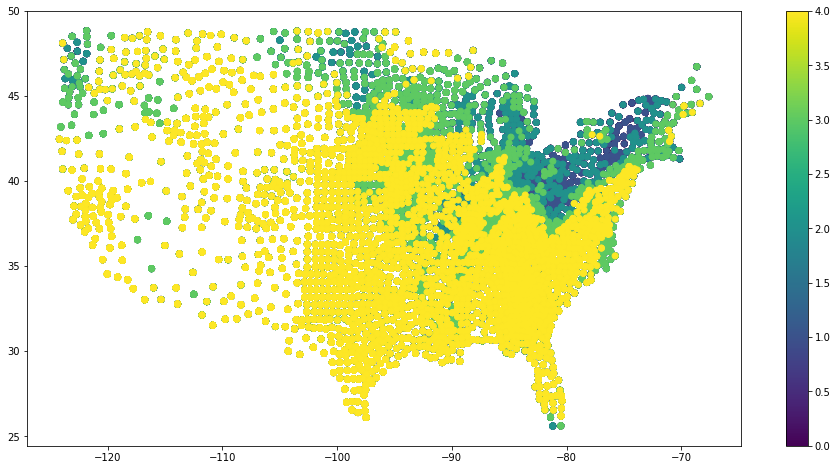

In [76]:
t = df[df['score']!=9]

plt.figure(figsize=(16, 8))

plt.scatter(t['lon'], t['lat'], c=t['score'])
plt.colorbar()

plt.savefig('scatter_map.png')
plt.show()

It seems that the geolocation matters when deciding the drought level

Some histograms are either left or right-skewed

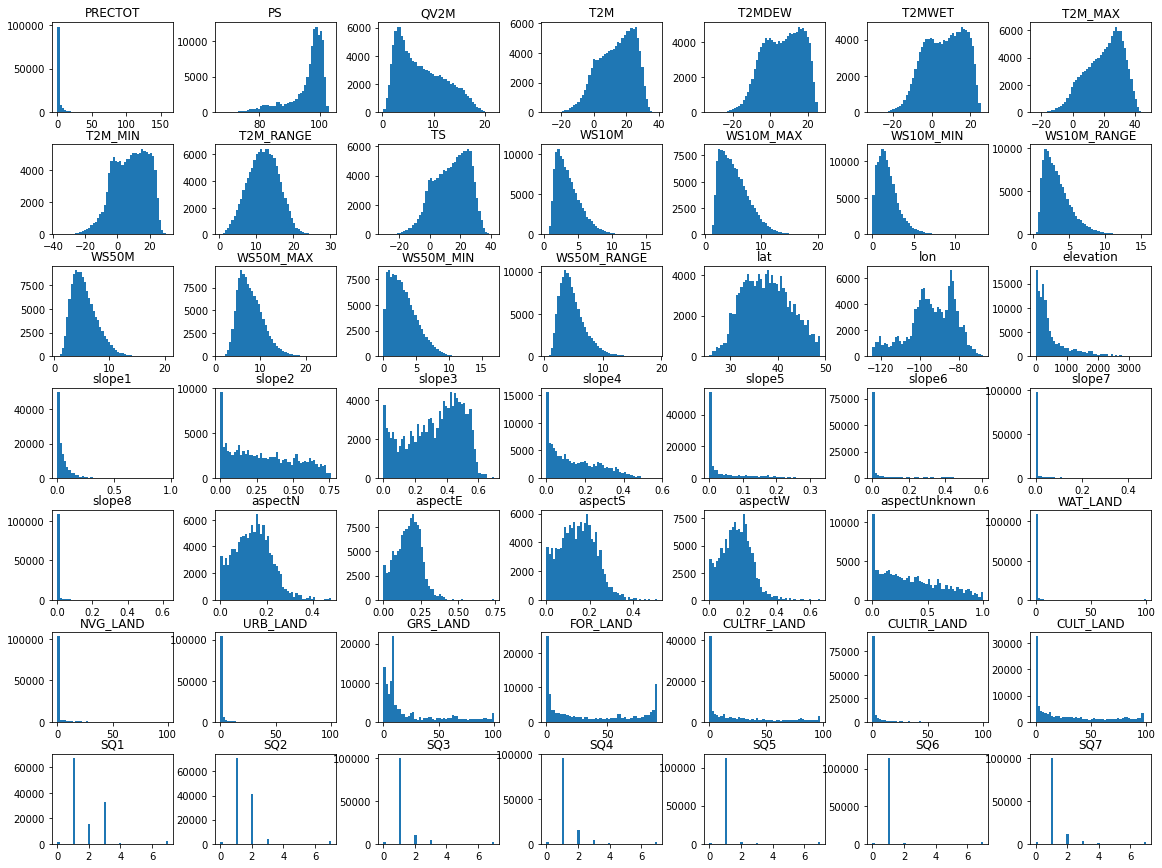

In [77]:
# Histogram for each feature
fig, ax = plt.subplots(7, 7, figsize=(16, 12))
fig.tight_layout()

for i in range(49):
    
    col = i % 7
    row = i // 7
    
    ax[row][col].hist(df.drop(columns=['fips', 'score']).iloc[:, i], bins=50)
    ax[row][col].set_title(df.drop(columns=['fips', 'score']).columns[i])
    
plt.savefig('features_histogram.png')
plt.show()

Many contains outliers. However it may not be ideal to remove them because features such as WAT_LAND, URB_LAND contain information that are critical to determine the drought level. Because this problem is class-imbalanced, we cannot rule out minority group of features.

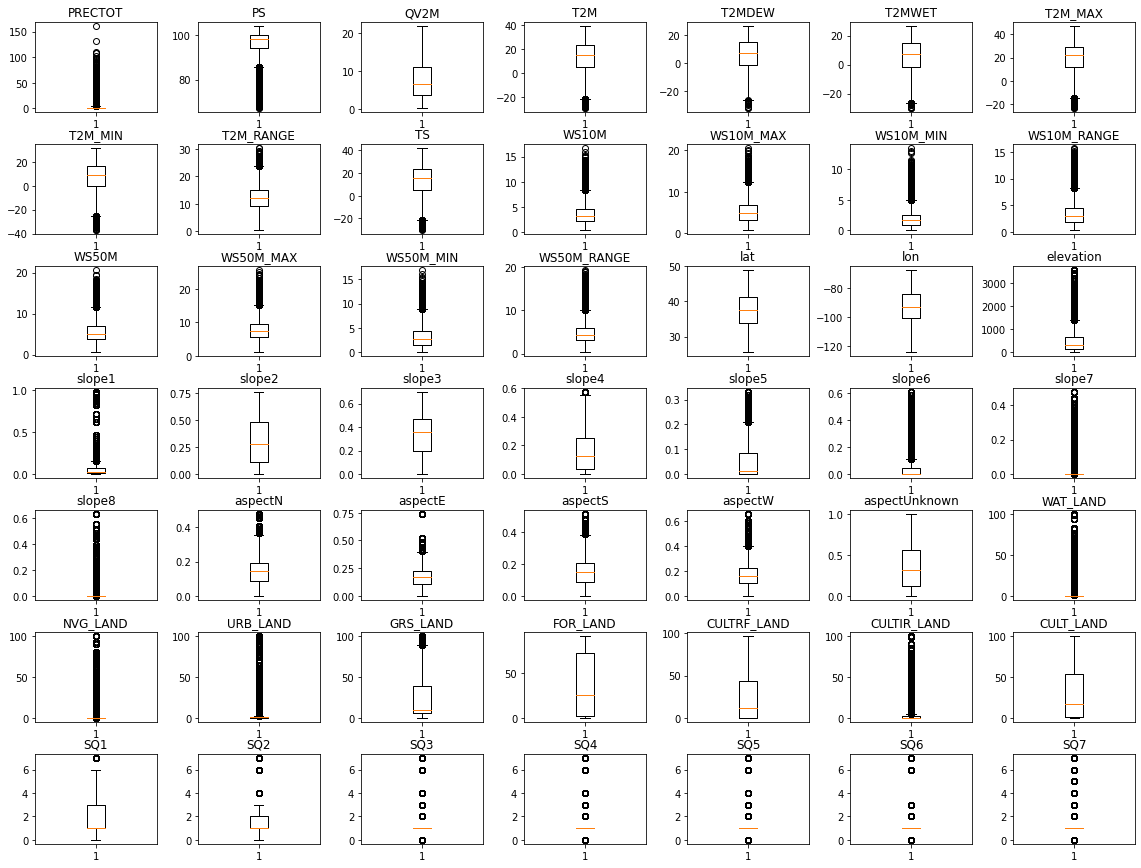

In [78]:
# Boxplot for each feature
fig, ax = plt.subplots(7, 7, figsize=(16, 12))
fig.tight_layout()

for i in range(49):
    
    col = i % 7
    row = i // 7
    
    ax[row][col].boxplot(df.drop(columns=['fips', 'score']).iloc[:, i])
    ax[row][col].set_title(df.drop(columns=['fips', 'score']).columns[i])

plt.savefig('features_boxplot.png')
plt.show()

In [17]:
# Remove all outliers using confidence interval.
columns_to_skip = ['lon', 'lat', 'score', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ6', 'SQ6', 'SQ7']

index_to_drop = []

for c in df.columns:
    
    if c in columns_to_skip:
        continue
        
    ind_mean = df[c].mean()
    ind_std = df[c].std()
    
    # Get 95% records. This will drop any 5% outliers
    ind = df[(df[c]>=ind_mean-ind_std*2) & (df[c]<=ind_mean+ind_std*2)]
    ind = ind.index
    ind = df[c].drop(index=ind)
    ind = ind.index.tolist()
    
    index_to_drop.extend(ind)
    
index_to_drop = set(index_to_drop)
len(index_to_drop)

72830

In [79]:
df = df.drop(index=index_to_drop)
df.index = list(range(df.shape[0]))

In [80]:
df['score'].value_counts()

4    8035
9    7960
0    7941
1    7833
2    7805
3    7596
Name: score, dtype: int64

In [81]:
# Standardize Data
ss = StandardScaler()
columns_not_standardized = ['fips', 'score', 'lat', 'lon', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']

no_cns_df = df[columns_not_standardized]
temp_df = df.drop(columns=columns_not_standardized)
temp_df = ss.fit_transform(temp_df)
temp_df = pd.DataFrame(temp_df, columns=df.drop(columns=columns_not_standardized).columns)

df = pd.concat([no_cns_df, temp_df], axis=1)

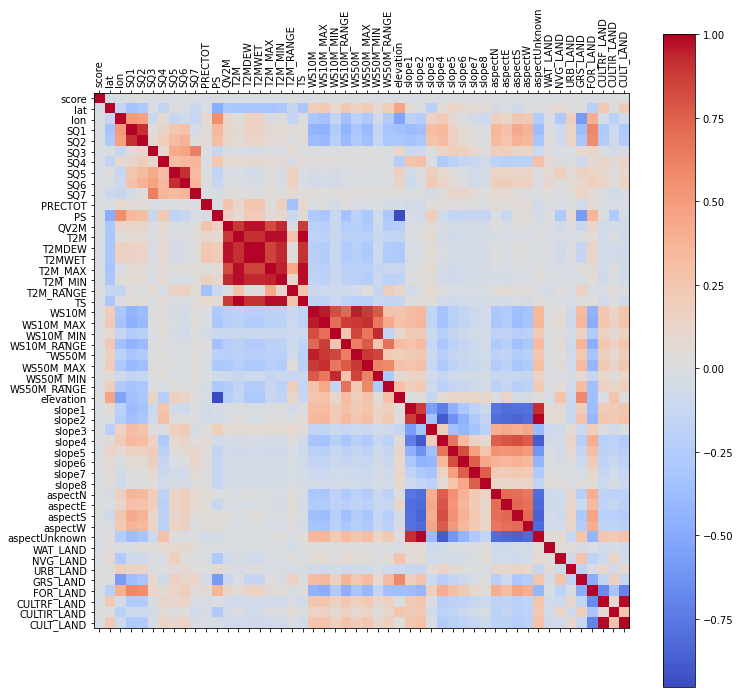

In [82]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
im = ax.matshow(df.iloc[:, 1:].corr(), cmap='coolwarm')
plt.xticks(range(df.columns[1:].shape[0]), df.columns[1:], rotation='vertical')
plt.yticks(range(df.columns[1:].shape[0]), df.columns[1:])
fig.colorbar(im, ax=ax)
plt.savefig('corr_map.png')
plt.show()

Grid search for PCA?

In [114]:
# Drop fips and aspectUnknown from the features.
X = df.drop(columns=['score', 'fips', 'aspectUnknown'])
y = df['score']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.15, random_state=random_state)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(40094, 48) (7076, 48) (40094,) (7076,)


In [115]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train[['elevation', 'lat', 'lon', 'GRS_LAND', 'CULTRF_LAND', 'CULTIR_LAND']], y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [118]:
preds = clf.predict(X_train[['elevation', 'lat', 'lon', 'GRS_LAND', 'CULTRF_LAND', 'CULTIR_LAND']])
valid_preds = clf.predict(X_valid[['elevation', 'lat', 'lon', 'GRS_LAND', 'CULTRF_LAND', 'CULTIR_LAND']])

loss = mean_squared_error(y_train, preds)
valid_loss = mean_squared_error(y_valid, valid_preds)

print('Training Loss :', loss)
print('Validation Loss :', valid_loss)
print('Train Accuracy :', (y_train==preds).sum()/y_train.shape[0])
print('Valid Accuracy :', (y_valid==valid_preds).sum()/y_valid.shape[0])

Training Loss : 13.053723749189405
Validation Loss : 14.469050310910118
Train Accuracy : 0.32772983488801316
Valid Accuracy : 0.25141322781232334


In [55]:
# Do not do PCA on lon and lat
# We do not want to lose our information on geolocation
n_components = 15

train_lon_lat = X_train[['lon', 'lat']]
valid_lon_lat = X_valid[['lon', 'lat']]

X_train = X_train.drop(columns=['lon', 'lat'])
X_valid = X_valid.drop(columns=['lon', 'lat'])

pca = PCA(n_components=n_components).fit(X_train)

X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)

X_train = np.concatenate((train_lon_lat.values, X_train), axis=1)
X_valid = np.concatenate((valid_lon_lat.values, X_valid), axis=1)

print(X_train.shape, X_valid.shape)

(40094, 48) (7076, 48) (40094,) (7076,)
(40094, 17) (7076, 17)


In [271]:
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, learning_rate=.25,
                            objective='multi:softprob', booster='gbtree', reg_alpha=20, reg_lambda=20,
                            n_jobs=10, random_state=random_state)

xgb_clf.fit(X_train,y_train)

preds = xgb_clf.predict(X_train)
valid_preds = xgb_clf.predict(X_valid)

loss = mean_squared_error(y_train, preds)
valid_loss = mean_squared_error(y_valid, valid_preds)

print('Training Loss :', loss)
print('Validation Loss :', valid_loss)
print('Train Accuracy :', (y_train==preds).sum()/y_train.shape[0])
print('Valid Accuracy :', (y_valid==valid_preds).sum()/y_valid.shape[0])

[13:03:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Loss : 9.073770818789269
Validation Loss : 15.32229443345578
Train Accuracy : 0.5304876832552109
Valid Accuracy : 0.29115569369878497


In [272]:
rfc = RandomForestClassifier(n_estimators=150, random_state=random_state)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_train)
valid_preds = rfc.predict(X_valid)

loss = mean_squared_error(y_train, preds)
valid_loss = mean_squared_error(y_valid, valid_preds)

print('Training Loss :', loss)
print('Validation Loss :', valid_loss)
print('Train Accuracy :', (y_train==preds).sum()/y_train.shape[0])
print('Valid Accuracy :', (y_valid==valid_preds).sum()/y_valid.shape[0])

Training Loss : 0.0
Validation Loss : 15.708335688047471
Train Accuracy : 1.0
Valid Accuracy : 0.2827917490816615


In [56]:
model = Sequential()
model.add(Dense(512, input_shape=(17,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [65]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [66]:
# This is only for nn model. label 5 is equal to 9 which indicates no drought
labels = y_train.copy()
labels.loc[y_train==9] = 5

valid_labels = y_valid.copy()
valid_labels.loc[valid_labels==9] = 5

In [69]:
model.fit(X_train, labels, epochs=100, verbose=0)

In [70]:
preds = model.predict(X_train).argmax(axis=1)
valid_preds = model.predict(X_valid).argmax(axis=1)

loss = mean_squared_error(labels, preds)
valid_loss = mean_squared_error(valid_labels, valid_preds)

print('Training Loss :', loss)
print('Validation Loss :', valid_loss)
print('Train Accuracy :', (labels==preds).sum()/labels.shape[0])
print('Valid Accuracy :', (valid_labels==valid_preds).sum()/valid_labels.shape[0])

Training Loss : 4.854491943931761
Validation Loss : 5.258055398530243
Train Accuracy : 0.3305980944779768
Valid Accuracy : 0.26936122102882987
